In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2

import esim_torch

/home/gwp/miniconda3/envs/vid2e/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading images
Loading data to GPU
Generating events
Plotting


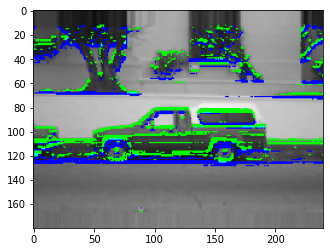

In [3]:
# fuling提供的样例代码
esim = esim_torch.ESIM(contrast_threshold_neg=0.2,
                        contrast_threshold_pos=0.2,
                        refractory_period_ns=0)

print("Loading images")
image_files = sorted(glob.glob("../../esim_py/tests/data/images/images/*.png"))
images = np.stack([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in image_files])
timestamps_s = np.genfromtxt("../../esim_py/tests/data/images/timestamps.txt")
timestamps_ns = (timestamps_s * 1e9).astype("int64")

log_images = np.log(images.astype("float32") / 255 + 1e-4)

# generate torch tensors
print("Loading data to GPU")
device = "cuda:0"
log_images = torch.from_numpy(log_images).to(device)
timestamps_ns = torch.from_numpy(timestamps_ns).to(device)

# generate events with GPU support
print("Generating events")
events = esim.forward(log_images, timestamps_ns)

# render events 
image = images[0]

print("Plotting")
first_few_events = {k: v[:10000].cpu().numpy() for k,v in events.items()}
image_color = np.stack([image,image,image],-1)
image_color[first_few_events['y'], first_few_events['x'], :] = 0
image_color[first_few_events['y'], first_few_events['x'], first_few_events['p']] = 255

plt.imshow(image_color)
plt.show()

Loading images
Loading data to GPU
Generating events
Plotting


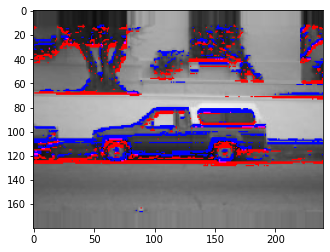

画出Space-time plot;事件数目  10000


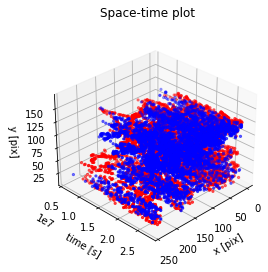

画出event_frame; 事件数目  10000


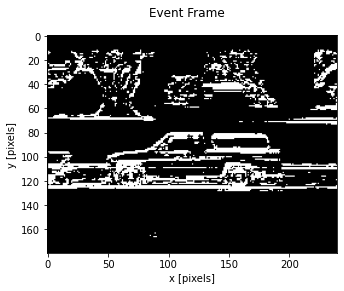

画出2D Histograms of events; 事件数目  10000


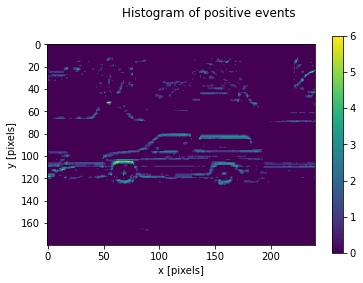

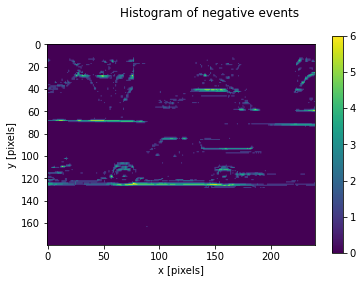

画出Ternary image; 事件数目  10000


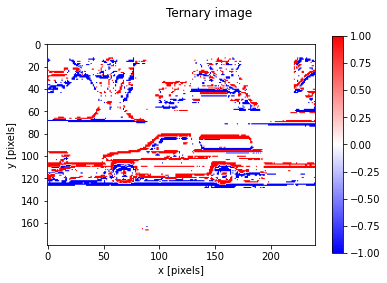

画出Time surface; 事件数目  10000


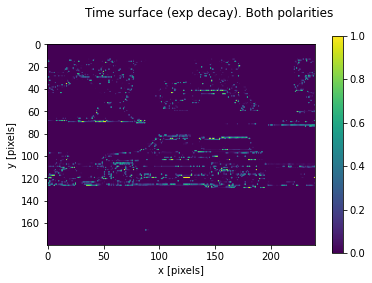

In [75]:
esim = esim_torch.ESIM(contrast_threshold_neg=0.2, #定义负event的阈值
                        contrast_threshold_pos=0.2, #定义正event的阈值
                        refractory_period_ns=0)  #refractory period in nanoseconds

print("Loading images")
# 读取图片
image_files = sorted(glob.glob("../../esim_py/tests/data/images/images/*.png"))
images = np.stack([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in image_files])
# 读取时间戳
timestamps_s = np.genfromtxt("../../esim_py/tests/data/images/timestamps.txt")
timestamps_ns = (timestamps_s * 1e9).astype("int64")

# 将图片转换为log scale
log_images = np.log(images.astype("float32") / 255 + 1e-4)

# generate torch tensors
print("Loading data to GPU")
device = "cuda:0"
# torch tensor with type float32, shape T x H x W
log_images = torch.from_numpy(log_images).to(device)
# torch tensor with type int64,   shape T 
timestamps_ns = torch.from_numpy(timestamps_ns).to(device)

# generate events with GPU support
print("Generating events")
events = esim.forward(log_images, timestamps_ns)

# 将生成的事件画在图像上 
image = images[0] #读取第一张图片

print("Plotting")
# 画出前10000个事件
num_event=10000;
first_few_events = {k: v[:num_event].cpu().numpy() for k,v in events.items()}
image_color = np.stack([image,image,image],-1)#将三个图像叠加，并沿着最后一个维度堆叠，形成一个彩色图像（RGB）。
image_color[first_few_events['y'], first_few_events['x'], :] = 0 #将事件的位置设置为黑色
# 由于是BGR，所以-1的时候，对应1-1是蓝色，1的时候，1+1是红色
image_color[first_few_events['y'], first_few_events['x'], 1+first_few_events['p']] = 255

plt.imshow(image_color)
plt.show()

# 用各种不同的方式来画图
print("画出Space-time plot;事件数目 ", num_event)
# %% Plot each polarity with a different color (red / blue)
idx_pos = np.asarray(first_few_events['p'][:num_event]) > 0 #正事件
idx_neg = np.logical_not(idx_pos) #负事件
xnp = np.asarray(first_few_events['x'][:num_event])
ynp = np.asarray(first_few_events['y'][:num_event])
tnp = np.asarray(first_few_events['t'][:num_event])
# 创建 3D 图形对象
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# 绘制三维散点图
ax.scatter(xnp[idx_pos], tnp[idx_pos], ynp[idx_pos], marker='.', c='b')
ax.scatter(xnp[idx_neg], tnp[idx_neg], ynp[idx_neg], marker='.', c='r')
# 设置坐标轴标签
ax.set(xlabel='x [pix]', ylabel='time [s]', zlabel='y [pix]')
# 视角设置
# ax.view_init(azim=-90, elev=-180) # Change viewpoint with the mouse, for example
ax.view_init(azim=45, elev=30) # 改变视角以便看到三维效果
fig.suptitle('Space-time plot')
# 显示图形
plt.show()

print("画出event_frame; 事件数目 ", num_event)
img_size = image.shape
event_frame = np.zeros(shape=img_size, dtype=int)

for i in range(num_event):
    event_frame[first_few_events['y'][i], first_few_events['x'][i]] = abs(first_few_events['p'][i])

# draw image
fig = plt.figure()
fig.suptitle('Event Frame')
plt.imshow(event_frame, cmap='gray', vmin=0, vmax=1)
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
# plt.colorbar()
plt.show()

print("画出2D Histograms of events; 事件数目 ", num_event)
img_pos = np.zeros(img_size, np.int)
img_neg = np.zeros(img_size, np.int)
for i in range(num_event):
    if (first_few_events['p'][i] > 0):
        img_pos[first_few_events['y'][i],first_few_events['x'][i]] += 1 # count events
    else:
        img_neg[first_few_events['y'][i],first_few_events['x'][i]] += 1

fig = plt.figure()
fig.suptitle('Histogram of positive events')
plt.imshow(img_pos)
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

fig = plt.figure()
fig.suptitle('Histogram of negative events')
plt.imshow(img_neg)
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

print("画出Ternary image; 事件数目 ", num_event)
# What if we only use 3 values in the event accumulation image?
# Saturated signal: -1, 0, 1
# For example, store the polarity of the last event at each pixel
Ternaryimage = np.zeros(img_size, np.int)
for i in range(num_event):
    Ternaryimage[first_few_events['y'][i],first_few_events['x'][i]] = (first_few_events['p'][i])  # no accumulation; overwrite the stored value

# Display the ternary image
fig = plt.figure()
fig.suptitle('Ternary image')
plt.imshow(Ternaryimage, cmap='bwr')
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()


first_few_events['t'] = first_few_events['t'] / first_few_events['t'].max()
num_event=num_event
print("画出Time surface; 事件数目 ", num_event)
Timesurface = np.zeros(img_size, np.float64)
t_ref = first_few_events['t'][-1] # time of the last event in the packet
tau = 0.03 # decay parameter (in seconds)
for i in range(num_event):
    Timesurface[first_few_events['y'][i],first_few_events['x'][i]] = np.exp(-(t_ref-first_few_events['t'][i]) / tau)

fig = plt.figure()
fig.suptitle('Time surface (exp decay). Both polarities')
plt.imshow(Timesurface)
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()


